In [1]:
# Import packages
import pandas as pd, numpy as np
import os, sys, glob, re
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import table
import statsmodels.api as sm
import geopandas as gpd
from statsmodels.iolib.summary2 import summary_col

# Get data

## 1. Exports

In [2]:
df_exports = pd.read_csv(r'C:\Users\jasonjia\Dropbox\projects\replication_cities_hetfirms\data\exports_ita.csv')
# Process df_exports
df_exports = df_exports[['MSA Full Name', '2012']].dropna()
df_exports.columns = ['msa_name', 'exports_2012']
# Remove non/other areas
df_exports = df_exports.iloc[:-2,:]
df_exports = df_exports.reset_index(drop=True)
df_exports['msa_name'] = df_exports['msa_name'].str.strip()
df_exports

,msa_name,exports_2012
0,"Abilene, TX",9.291774e+07
1,"Aguadilla-Isabela, PR",6.370887e+08
2,"Akron, OH",3.821459e+09
3,"Albany, GA",2.816581e+08
4,"Albany-Schenectady-Troy, NY",3.420058e+09
...,...,...
365,"Yauco, PR",5.304613e+07
366,"York-Hanover, PA",1.888985e+09
367,"Youngstown-Warren-Boardman, OH-PA",1.211892e+09
368,"Yuba City, CA",3.091096e+08


## 2. Population

In [3]:
def replace_msa_names(df_col):
    df_col = df_col.str.replace('Mayagüez, PR', 'Mayaguez, PR')
    df_col = df_col.str.replace('Nashville-Davidson--Murfreesboro--Franklin, TN', 'Nashville-Davidson-Murfreesboro-Franklin, TN')
    df_col = df_col.str.replace('San Germán, PR', 'San German, PR')
    df_col = df_col.str.replace('San Juan-Bayamón-Caguas, PR', 'San Juan-Bayamon-Caguas, PR')
    df_col = df_col.str.replace('Scranton--Wilkes-Barre, PA', 'Scranton-Wilkes-Barre, PA')
    return df_col

In [4]:
df_pop = pd.read_excel(r'C:\Users\jasonjia\Dropbox\projects\replication_cities_hetfirms\data\cbsa-met-est2019-annres.xlsx', skiprows=3)
# Process df_pop
df_pop = df_pop.iloc[2:-5,[0,5]]
df_pop.columns = ['msa_name', 'pop_2012']
df_pop = df_pop.dropna()
# Remove all metro divisions
df_pop = df_pop[~df_pop['msa_name'].str.contains('Metro Division')]
# Remove the starting '.' and ending 'Metro Area'
df_pop['msa_name'] = df_pop['msa_name'].str.strip()
df_pop['msa_name'] = df_pop['msa_name'].str.replace('^\.', '', regex=True)
df_pop['msa_name'] = df_pop['msa_name'].str.replace('Metro Area', '')
df_pop['msa_name'] = df_pop['msa_name'].str.strip()
# Replace certain MSA names to match with df_exports later on
df_pop['msa_name'] = replace_msa_names(df_pop['msa_name'])
df_pop = df_pop.reset_index(drop=True)
df_pop

,msa_name,pop_2012
0,"Abilene, TX",167442.0
1,"Akron, OH",702109.0
2,"Albany, GA",153976.0
3,"Albany-Lebanon, OR",118273.0
4,"Albany-Schenectady-Troy, NY",874698.0
...,...,...
389,"Mayaguez, PR",111845.0
390,"Ponce, PR",253345.0
391,"San German, PR",135185.0
392,"San Juan-Bayamon-Caguas, PR",2295419.0


In [5]:
# Merge df_pop (394 rows) with df_exports (370 rows), keeping only entries in both tables
# Note that only 6 rows are lost from df_exports, so this is a good match.
df_pop_exports = df_pop.merge(df_exports, on='msa_name', how='inner')
df_pop_exports

,msa_name,pop_2012,exports_2012
0,"Abilene, TX",167442.0,9.291774e+07
1,"Akron, OH",702109.0,3.821459e+09
2,"Albany, GA",153976.0,2.816581e+08
3,"Albany-Schenectady-Troy, NY",874698.0,3.420058e+09
4,"Albuquerque, NM",901939.0,1.790610e+09
...,...,...,...
358,"Mayaguez, PR",111845.0,1.096283e+07
359,"Ponce, PR",253345.0,5.754300e+08
360,"San German, PR",135185.0,1.093687e+08
361,"San Juan-Bayamon-Caguas, PR",2295419.0,1.759624e+10


## 3. MSA code -> MSA name crosswalk

In [6]:
msa_crosswalk = pd.read_csv(r'C:\Users\jasonjia\Dropbox\projects\replication_cities_hetfirms\data\msa_crosswalk.csv',skiprows=2)
# Process msa_crosswalk
msa_crosswalk = msa_crosswalk.iloc[:-3,:]
msa_crosswalk = msa_crosswalk[msa_crosswalk['Metropolitan/Micropolitan Statistical Area'] == 'Metropolitan Statistical Area']
msa_crosswalk = msa_crosswalk[['CBSA Code', 'CBSA Title']]
msa_crosswalk.columns = ['msa', 'msa_name']
msa_crosswalk = msa_crosswalk.dropna()
msa_crosswalk['msa'] = msa_crosswalk['msa']
msa_crosswalk['msa_name'] = msa_crosswalk['msa_name'].str.strip()
print('msa_crosswalk.shape:', msa_crosswalk.shape)
# Remove duplicated MSAs (note that there is a 1:1 match from msa to msa_name)
msa_crosswalk = msa_crosswalk.drop_duplicates(['msa', 'msa_name'])
print('msa_crosswalk.shape:', msa_crosswalk.shape)
msa_crosswalk = msa_crosswalk.drop_duplicates('msa_name')
print('msa_crosswalk.shape:', msa_crosswalk.shape)
msa_crosswalk

msa_crosswalk.shape: (1236, 2)
msa_crosswalk.shape: (388, 2)
msa_crosswalk.shape: (388, 2)


,msa,msa_name
3,10180,"Abilene, TX"
9,10380,"Aguadilla-Isabela, PR"
18,10420,"Akron, OH"
21,10500,"Albany, GA"
26,10540,"Albany, OR"
...,...,...
1871,49420,"Yakima, WA"
1873,49620,"York-Hanover, PA"
1874,49660,"Youngstown-Warren-Boardman, OH-PA"
1877,49700,"Yuba City, CA"


## 4. Sales

In [7]:
def get_df_sales(inputfilepath, naics):
    # Process df_sales (Note: The dataset is only for 2012. RCPTOT = Value of sales, shipments, receipts, revenue, or business done ($1,000))
    # EC1200A1.dat (all sectors), EC1231A1 (manufacturing, 31-33)
    df_sales = pd.read_csv(inputfilepath, sep='|', usecols=['MSA', 'RCPTOT', 'NAICS2012', 'NAICS2012_TTL'])
    # Note that this dataset contains the value of sales for NAICS2, NAICS3, NAICS4, NAICS5 and NAICS6. 
    # We only want to keep the sales for NAICS2 to avoid double-counting.
    # Note that some NAICS2 occupy multiple 2-digit codes, so their code looks like '31-33' instead.
    
    # If we are adding up across all NAICS2s: 
    # We add up all sectors excluding '00' ('Total for all sectors'), rather than use '00' directly.
    # This is because '00' does not appear for most MSAs.
    if naics == 'All':
        df_sales = df_sales[(df_sales['NAICS2012'].str.len() == 2) | (df_sales['NAICS2012'].str.contains('-'))]
        df_sales = df_sales[df_sales['NAICS2012'] != '00']
    
    # If we are only using manufacturing NAICS (31-33):
    # Keep only naics = '31-33'.
    elif naics == '31-33':
        df_sales = df_sales[df_sales['NAICS2012'].isin(['31-33'])]
    
    # Print the NAICS codes remaining
    print("Unique NAICS2:", [','.join(df_sales['NAICS2012'].unique())])

    # Each MSA has multiple rows, one for each NAICS2. We aggregate by taking the sum across all NAICS.
    df_sales = df_sales.groupby('MSA').sum('RCPTOT').reset_index()
    df_sales.columns = ['msa', 'sales_2012']
    df_sales['msa'] = df_sales['msa'].astype('str').str.zfill(5)
    df_sales['sales_2012'] = df_sales['sales_2012'] * 1000 # because the column is in 1000s.
    df_sales = df_sales[df_sales['sales_2012'] > 0]
    print("Number of unique MSAs:", df_sales['msa'].nunique())
    
    return df_sales

## 5. Land area

In [8]:
df_landarea_filepath = Path(r'C:\Users\jasonjia\Dropbox\projects\replication_cities_hetfirms\data\tl_2012_us_cbsa\tl_2012_us_cbsa.shp')
df_landarea = gpd.read_file(df_landarea_filepath)
df_landarea = df_landarea[['GEOID', 'NAME', 'ALAND']]
df_landarea.columns = ['msa', 'msa_name_shp', 'landarea_2012']
# Land area measurements are originally recorded as whole square meters, but we want square miles.
# To convert square meters to square kilometers, divide by 1,000,000; 
# To convert square kilometers to square miles, divide by 2.58999; 
# To convert square meters to square miles, divide by 2,589,988.
df_landarea['landarea_2012'] = df_landarea['landarea_2012'] / 2589988
df_landarea

,msa,msa_name_shp,landarea_2012
0,25900,"Hilo, HI",4028.437050
1,14580,"Bozeman, MT",2602.712284
2,31620,"Magnolia, AR",766.054102
3,28740,"Kingston, NY",1124.235059
4,11820,"Astoria, OR",829.076706
...,...,...,...
950,40140,"Riverside-San Bernardino-Ontario, CA",27263.543046
951,31100,"Los Angeles-Long Beach-Santa Ana, CA",4848.710440
952,39820,"Redding, CA",3775.377478
953,43320,"Show Low, AZ",9950.435071


## 6. Local industry shares (Share of employment by industry in each MSA)

In [9]:
df_emp_counts = pd.read_csv(r'C:\Users\jasonjia\Dropbox\projects\replication_cities_hetfirms\data\employment_by_industry.csv', skiprows=3)
# Process initial table
df_emp_counts = df_emp_counts.iloc[:-9,:]
df_emp_counts.columns = ['msa', 'msa_name', 'ind', 'ind_name', 'emp_count_2012']
df_emp_counts = df_emp_counts.dropna()
df_emp_counts = df_emp_counts[df_emp_counts['emp_count_2012'] != '(D)'] # Drop rows where count is not shown to avoid disclosure of confidential information
df_emp_counts['emp_count_2012'] = df_emp_counts['emp_count_2012'].replace('15,375 E', '15375') # Remove the one row where count = '15,375 E'
df_emp_counts['emp_count_2012'] = df_emp_counts['emp_count_2012'].astype('int64')
df_emp_counts['ind'] = df_emp_counts['ind'].astype('int64')

# Get industry counts (by MSA)
df_emp_ind_counts = df_emp_counts[df_emp_counts['ind'].isin([70,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000])]

# Get total counts (by MSA)
df_emp_total_counts = df_emp_counts[df_emp_counts['ind'] == 10][['msa', 'emp_count_2012']]
df_emp_total_counts.columns = ['msa', 'emp_total_count_2012']

# Merge industry counts with total counts and get share (by MSA)
df_emp_ind_share = df_emp_ind_counts.merge(df_emp_total_counts, on='msa', how='inner')
df_emp_ind_share['emp_share_2012'] = df_emp_ind_share['emp_count_2012'] / df_emp_ind_share['emp_total_count_2012']
df_emp_ind_share

,msa,msa_name,ind,ind_name,emp_count_2012,emp_total_count_2012,emp_share_2012
0,00998,United States (Metropolitan Portion),70,Farm employment,1286007,155994342,0.008244
1,00998,United States (Metropolitan Portion),100,"Forestry, fishing, and related activities",562925,155994342,0.003609
2,00998,United States (Metropolitan Portion),200,"Mining, quarrying, and oil and gas extra...",1004023,155994342,0.006436
3,00998,United States (Metropolitan Portion),300,Utilities,461318,155994342,0.002957
4,00998,United States (Metropolitan Portion),400,Construction,7633690,155994342,0.048936
...,...,...,...,...,...,...,...
5993,49740,"Yuma, AZ (Metropolitan Statistical Area)",1600,Health care and social assistance,8206,82389,0.099601
5994,49740,"Yuma, AZ (Metropolitan Statistical Area)",1700,"Arts, entertainment, and recreation",812,82389,0.009856
5995,49740,"Yuma, AZ (Metropolitan Statistical Area)",1800,Accommodation and food services,5393,82389,0.065458
5996,49740,"Yuma, AZ (Metropolitan Statistical Area)",1900,Other services (except government and go...,3700,82389,0.044909


In [10]:
# View employment industries
emp_ind_list = df_emp_ind_share[['ind', 'ind_name']].drop_duplicates()
emp_ind_list['ind_abbr'] = ['farm', 'forestry', 'mining', 'utilities', 'construction', 'manufacturing', 'wholesale_trade', 'retail_trade', 
                            'transport', 'information', 'finance', 'real_estate', 'professional', 'management', 'admin', 'education', 'healthcare', 
                            'arts', 'accommodation', 'other', 'government']
emp_ind_list

,ind,ind_name,ind_abbr
0,70,Farm employment,farm
1,100,"Forestry, fishing, and related activities",forestry
2,200,"Mining, quarrying, and oil and gas extra...",mining
3,300,Utilities,utilities
4,400,Construction,construction
5,500,Manufacturing,manufacturing
6,600,Wholesale trade,wholesale_trade
7,700,Retail trade,retail_trade
8,800,Transportation and warehousing,transport
9,900,Information,information


In [11]:
# Merge ind_abbr back to df_emp_ind_share
df_emp_ind_share = df_emp_ind_share.merge(emp_ind_list[['ind', 'ind_abbr']], on='ind', how='inner')
df_emp_ind_share

,msa,msa_name,ind,ind_name,emp_count_2012,emp_total_count_2012,emp_share_2012,ind_abbr
0,00998,United States (Metropolitan Portion),70,Farm employment,1286007,155994342,0.008244,farm
1,10180,"Abilene, TX (Metropolitan Statistical Area)",70,Farm employment,3128,99843,0.031329,farm
2,10420,"Akron, OH (Metropolitan Statistical Area)",70,Farm employment,1378,412049,0.003344,farm
3,10500,"Albany, GA (Metropolitan Statistical Area)",70,Farm employment,1417,79388,0.017849,farm
4,10540,"Albany-Lebanon, OR (Metropolitan Statistical A...",70,Farm employment,3544,55676,0.063654,farm
...,...,...,...,...,...,...,...,...
5993,49420,"Yakima, WA (Metropolitan Statistical Area)",2000,Government and government enterprises,17883,124847,0.143239,government
5994,49620,"York-Hanover, PA (Metropolitan Statistical Area)",2000,Government and government enterprises,21971,225936,0.097244,government
5995,49660,"Youngstown-Warren-Boardman, OH-PA (Metropolita...",2000,Government and government enterprises,31406,287302,0.109314,government
5996,49700,"Yuba City, CA (Metropolitan Statistical Area)",2000,Government and government enterprises,15574,63966,0.243473,government


In [12]:
# Pivot employment shares
# Columns of interest: manufacturing (500), wholesale trade (600), retail trade (700), government (2000)
df_emp_ind_share_pivot = df_emp_ind_share[['msa', 'ind_abbr', 'emp_share_2012']].pivot(index='msa', columns='ind_abbr', values='emp_share_2012')
df_emp_ind_share_pivot.columns = [f'emp_share_2012_{col_name}' for col_name in df_emp_ind_share_pivot.columns]
df_emp_ind_share_pivot = df_emp_ind_share_pivot.reset_index()
df_emp_ind_share_pivot

,msa,emp_share_2012_accommodation,emp_share_2012_admin,emp_share_2012_arts,emp_share_2012_construction,emp_share_2012_education,emp_share_2012_farm,emp_share_2012_finance,emp_share_2012_forestry,emp_share_2012_government,...,emp_share_2012_management,emp_share_2012_manufacturing,emp_share_2012_mining,emp_share_2012_other,emp_share_2012_professional,emp_share_2012_real_estate,emp_share_2012_retail_trade,emp_share_2012_transport,emp_share_2012_utilities,emp_share_2012_wholesale_trade
0,00998,0.071236,0.064830,0.023167,0.048936,0.025009,0.008244,0.057135,0.003609,0.130642,...,0.013236,0.065268,0.006436,0.057933,0.073493,0.045707,0.099856,0.032799,0.002957,0.036148
1,10180,NaN,NaN,NaN,0.057671,NaN,0.031329,0.061396,NaN,0.177749,...,NaN,0.030288,0.060986,0.059634,NaN,0.029116,0.103713,0.020833,0.003726,0.029967
2,10420,0.066043,0.062480,0.021422,0.046393,0.017903,0.003344,0.043165,0.000973,0.120838,...,0.038175,0.100464,0.005652,0.054421,0.059595,0.035370,0.104002,NaN,NaN,0.047936
3,10500,NaN,NaN,NaN,0.044994,NaN,0.017849,0.033935,NaN,0.184373,...,NaN,0.057150,NaN,0.082355,0.045989,0.028669,0.109349,NaN,NaN,0.035698
4,10540,0.054368,0.051423,0.016075,0.049788,0.014099,0.063654,0.024625,NaN,0.119693,...,0.004400,0.131044,NaN,0.055284,0.032474,0.038544,0.112149,0.051943,0.003035,0.029546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,49420,0.049949,0.022043,0.014185,0.032608,0.013865,0.145354,0.025111,0.069757,0.143239,...,0.004934,0.066778,0.001330,0.042957,0.027442,0.027017,0.099690,0.030958,0.001306,0.035652
381,49620,0.062867,0.056003,0.017558,0.066727,0.017222,0.013238,0.031805,0.001717,0.097244,...,0.017562,0.145138,0.001970,0.061424,0.044800,0.037077,0.122207,0.042844,0.005714,0.031345
382,49660,0.075092,0.069404,0.016798,0.050497,0.014772,0.010616,0.036467,NaN,0.109314,...,0.009426,0.111980,NaN,0.060076,0.034967,0.032032,0.122731,0.035997,0.002384,0.032875
383,49700,0.061392,0.045884,0.015883,0.038427,0.008098,0.065410,0.026029,0.032048,0.243473,...,0.004549,0.038395,0.004690,0.050965,0.034237,0.036770,0.111262,0.038927,NaN,NaN


# Merge data, filter and process df

In [13]:
def merge_datasets(df_sales, msa_crosswalk, df_pop_exports, df_landarea, df_emp_ind_share_pivot):
    # Merge df_sales with MSA crosswalk. Note that note all MSAs in df_sales are valid, and we only keep the inner merge.
    # We see that no rows from MSA crosswalk are lost, which is good.
    print('df.shape (df_sales):', df_sales.shape)
    df1 = df_sales.merge(msa_crosswalk, on='msa', how='inner')
    print('df.shape (df_sales + msa_crosswalk):', df1.shape)
    # Merge df_pop_exports with df_sales.
    df2 = df_pop_exports.merge(df1, on='msa_name', how='inner')
    print('df.shape (df_sales + msa_crosswalk + df_pop_exports):', df2.shape)
    # Get export intensity = exports / sales
    df2['export_intensity_2012'] = df2['exports_2012'] / df2['sales_2012']
    # Merge with df_landarea
    df3 = df2.merge(df_landarea, on='msa', how='inner')
    # Get population density = pop / landarea
    df3['pop_density_2012'] = df3['pop_2012'] / df3['landarea_2012']
    print("MSAs dropped from merge with df_landarea:\n", df2[~df2['msa'].isin(df3['msa'].tolist())][['msa_name', 'msa']]) # See which MSAs are dropped
    print('df.shape (df_sales + msa_crosswalk + df_pop_exports + df_landarea):', df3.shape)
    # Merge with df_emp_ind_share_pivot
    df4 = df3.merge(df_emp_ind_share_pivot, on='msa', how='inner')
    print('df.shape (df_sales + msa_crosswalk + df_pop_exports + df_landarea + df_emp_ind_share_pivot):', df4.shape)
    return df4

In [14]:
def filter_and_process_df(df):
    # Filter for pop > 100000 and exports > 0
    print("df.shape:", df.shape) 
    df = df[df['pop_2012'] > 100000]
    print("df.shape (after filtering for pop > 100000):", df.shape)
    df = df[df['exports_2012'] > 0] # no effect
    print("df.shape (after filtering for exports > 0):", df.shape)
    return df

In [15]:
sales_inputfilepath = Path(r'C:\Users\jasonjia\Dropbox\projects\replication_cities_hetfirms\data\EC1200A1.dat')

In [16]:
df_sales = get_df_sales(sales_inputfilepath, naics='All')
df = merge_datasets(df_sales, msa_crosswalk, df_pop_exports, df_landarea, df_emp_ind_share_pivot)
df = filter_and_process_df(df)
df

Unique NAICS2: ['21,22,23,31-33,42,44-45,48-49,51,52,53,54,55,56,61,62,71,72,81']
Number of unique MSAs: 930
df.shape (df_sales): (930, 2)
df.shape (df_sales + msa_crosswalk): (388, 3)
df.shape (df_sales + msa_crosswalk + df_pop_exports): (321, 5)
MSAs dropped from merge with df_landarea:
                                msa_name    msa
31                      Bloomington, IL  14010
157        Lafayette-West Lafayette, IN  29200
178  Los Angeles-Long Beach-Anaheim, CA  31080
265       Santa Maria-Santa Barbara, CA  42200
293                  Urban Honolulu, HI  46520
303         Weirton-Steubenville, WV-OH  48260
df.shape (df_sales + msa_crosswalk + df_pop_exports + df_landarea): (315, 9)
df.shape (df_sales + msa_crosswalk + df_pop_exports + df_landarea + df_emp_ind_share_pivot): (312, 30)
df.shape: (312, 30)
df.shape (after filtering for pop > 100000): (291, 30)
df.shape (after filtering for exports > 0): (291, 30)


,msa_name,pop_2012,exports_2012,msa,sales_2012,export_intensity_2012,msa_name_shp,landarea_2012,pop_density_2012,emp_share_2012_accommodation,...,emp_share_2012_management,emp_share_2012_manufacturing,emp_share_2012_mining,emp_share_2012_other,emp_share_2012_professional,emp_share_2012_real_estate,emp_share_2012_retail_trade,emp_share_2012_transport,emp_share_2012_utilities,emp_share_2012_wholesale_trade
0,"Abilene, TX",167442.0,9.291774e+07,10180,31351915000,0.002964,"Abilene, TX",2743.478801,61.032730,NaN,...,NaN,0.030288,0.060986,0.059634,NaN,0.029116,0.103713,0.020833,0.003726,0.029967
1,"Akron, OH",702109.0,3.821459e+09,10420,172481910000,0.022156,"Akron, OH",900.220261,779.930235,0.066043,...,0.038175,0.100464,0.005652,0.054421,0.059595,0.035370,0.104002,NaN,NaN,0.047936
2,"Albany, GA",153976.0,2.816581e+08,10500,26157249000,0.010768,"Albany, GA",1932.594317,79.673214,NaN,...,NaN,0.057150,NaN,0.082355,0.045989,0.028669,0.109349,NaN,NaN,0.035698
3,"Albany-Schenectady-Troy, NY",874698.0,3.420058e+09,10580,180600236000,0.018937,"Albany-Schenectady-Troy, NY",2811.635806,311.099325,0.061399,...,NaN,NaN,NaN,0.049208,0.079885,0.034719,0.104791,0.026498,0.003229,0.028503
4,"Albuquerque, NM",901939.0,1.790610e+09,10740,148919019000,0.012024,"Albuquerque, NM",9282.373647,97.166849,NaN,...,0.007542,0.041930,NaN,0.050807,NaN,0.039981,0.104493,NaN,NaN,0.029538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,"Yakima, WA",246127.0,1.164300e+09,49420,42530018000,0.027376,"Yakima, WA",4295.535540,57.298327,0.049949,...,0.004934,0.066778,0.001330,0.042957,0.027442,0.027017,0.099690,0.030958,0.001306,0.035652
308,"York-Hanover, PA",437466.0,1.888985e+09,49620,97424764000,0.019389,"York-Hanover, PA",904.181769,483.825283,0.062867,...,0.017562,0.145138,0.001970,0.061424,0.044800,0.037077,0.122207,0.042844,0.005714,0.031345
309,"Youngstown-Warren-Boardman, OH-PA",558530.0,1.211892e+09,49660,114528501000,0.010582,"Youngstown-Warren-Boardman, OH-PA",1702.383817,328.087000,0.075092,...,0.009426,0.111980,NaN,0.060076,0.034967,0.032032,0.122731,0.035997,0.002384,0.032875
310,"Yuba City, CA",166963.0,3.091096e+08,49700,14537591000,0.021263,"Yuba City, CA",1234.430635,135.255068,0.061392,...,0.004549,0.038395,0.004690,0.050965,0.034237,0.036770,0.111262,0.038927,NaN,NaN


In [17]:
df_sales_mfg = get_df_sales(sales_inputfilepath, naics='31-33')
df_mfg = merge_datasets(df_sales_mfg, msa_crosswalk, df_pop_exports, df_landarea, df_emp_ind_share_pivot)
df_mfg = filter_and_process_df(df_mfg)
df_mfg

Unique NAICS2: ['31-33']
Number of unique MSAs: 868
df.shape (df_sales): (868, 2)
df.shape (df_sales + msa_crosswalk): (385, 3)
df.shape (df_sales + msa_crosswalk + df_pop_exports): (319, 5)
MSAs dropped from merge with df_landarea:
                                msa_name    msa
30                      Bloomington, IL  14010
155        Lafayette-West Lafayette, IN  29200
176  Los Angeles-Long Beach-Anaheim, CA  31080
263       Santa Maria-Santa Barbara, CA  42200
291                  Urban Honolulu, HI  46520
301         Weirton-Steubenville, WV-OH  48260
df.shape (df_sales + msa_crosswalk + df_pop_exports + df_landarea): (313, 9)
df.shape (df_sales + msa_crosswalk + df_pop_exports + df_landarea + df_emp_ind_share_pivot): (310, 30)
df.shape: (310, 30)
df.shape (after filtering for pop > 100000): (290, 30)
df.shape (after filtering for exports > 0): (290, 30)


,msa_name,pop_2012,exports_2012,msa,sales_2012,export_intensity_2012,msa_name_shp,landarea_2012,pop_density_2012,emp_share_2012_accommodation,...,emp_share_2012_management,emp_share_2012_manufacturing,emp_share_2012_mining,emp_share_2012_other,emp_share_2012_professional,emp_share_2012_real_estate,emp_share_2012_retail_trade,emp_share_2012_transport,emp_share_2012_utilities,emp_share_2012_wholesale_trade
0,"Abilene, TX",167442.0,9.291774e+07,10180,3703065000,0.025092,"Abilene, TX",2743.478801,61.032730,NaN,...,NaN,0.030288,0.060986,0.059634,NaN,0.029116,0.103713,0.020833,0.003726,0.029967
1,"Akron, OH",702109.0,3.821459e+09,10420,36108577000,0.105832,"Akron, OH",900.220261,779.930235,0.066043,...,0.038175,0.100464,0.005652,0.054421,0.059595,0.035370,0.104002,NaN,NaN,0.047936
2,"Albany, GA",153976.0,2.816581e+08,10500,6677750000,0.042179,"Albany, GA",1932.594317,79.673214,NaN,...,NaN,0.057150,NaN,0.082355,0.045989,0.028669,0.109349,NaN,NaN,0.035698
3,"Albany-Schenectady-Troy, NY",874698.0,3.420058e+09,10580,19485869000,0.175515,"Albany-Schenectady-Troy, NY",2811.635806,311.099325,0.061399,...,NaN,NaN,NaN,0.049208,0.079885,0.034719,0.104791,0.026498,0.003229,0.028503
4,"Albuquerque, NM",901939.0,1.790610e+09,10740,18132185000,0.098753,"Albuquerque, NM",9282.373647,97.166849,NaN,...,0.007542,0.041930,NaN,0.050807,NaN,0.039981,0.104493,NaN,NaN,0.029538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,"Yakima, WA",246127.0,1.164300e+09,49420,6888248000,0.169027,"Yakima, WA",4295.535540,57.298327,0.049949,...,0.004934,0.066778,0.001330,0.042957,0.027442,0.027017,0.099690,0.030958,0.001306,0.035652
306,"York-Hanover, PA",437466.0,1.888985e+09,49620,32168351000,0.058722,"York-Hanover, PA",904.181769,483.825283,0.062867,...,0.017562,0.145138,0.001970,0.061424,0.044800,0.037077,0.122207,0.042844,0.005714,0.031345
307,"Youngstown-Warren-Boardman, OH-PA",558530.0,1.211892e+09,49660,37727670000,0.032122,"Youngstown-Warren-Boardman, OH-PA",1702.383817,328.087000,0.075092,...,0.009426,0.111980,NaN,0.060076,0.034967,0.032032,0.122731,0.035997,0.002384,0.032875
308,"Yuba City, CA",166963.0,3.091096e+08,49700,1793283000,0.172371,"Yuba City, CA",1234.430635,135.255068,0.061392,...,0.004549,0.038395,0.004690,0.050965,0.034237,0.036770,0.111262,0.038927,NaN,NaN


# Get tables, plot figures and run regressions

In [18]:
def run_reg(df, y, x_log=[], x_nolog=[]):
    df = df[y + x_log + x_nolog].dropna()
    model = sm.OLS(np.log(df[y]), sm.add_constant(pd.concat([np.log(df[x_log]), df[x_nolog]], axis=1)))
    results = model.fit()
    print(results.summary())
    output = summary_col([results], stars=True)
    print(output.as_latex())
    return results

In [19]:
def plot_regplot(df, x, x_log, y, y_log, x_label, y_label, title, savefig=''):
    if x_log:
        df_x = np.log(df[x])
    else:
        df_x = df[x]
    if y_log:
        df_y = np.log(df[y])
    else:
        df_y = df[y]
        
    # Plot
    fig, ax = plt.subplots(figsize=(7.5,6))
    sns.regplot(x=df_x, y=df_y, ci=None, scatter_kws={'color':'blue', 'facecolor':'None'}, line_kws={'color':'red'}, ax=ax)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    fig.tight_layout()
    
    # Save figure
    if savefig != '':
        fig.savefig(savefig, dpi=200)

## 1. Table 1: City Size and Export Intensity

In [20]:
def get_table1(df):
    # City size
    city_size_obtained = np.round((df['pop_2012'] / 1000).describe(percentiles=[0.25, 0.5, 0.75, 0.90, 0.95]),1)
    city_size_reported = pd.Series([312, 798.8, 'NA', 'NA', 157.5, 277.5, 636.6, 1929.2, 3176.1, 'NA'])
    city_size_reported.index = city_size_obtained.index
    
    # Export intensity
    export_intensity_obtained = np.round(df['export_intensity_2012'].describe(percentiles=[0.25, 0.5, 0.75, 0.90, 0.95]),4)
    export_intensity_reported = pd.Series(['312', '0.1131', 'NA', 'NA', '0.0445', '0.0853', '0.1370', '0.2250', '0.3292', 'NA'])
    export_intensity_reported.index = export_intensity_obtained.index
    
    table1 = pd.concat([city_size_obtained, city_size_reported, export_intensity_obtained, export_intensity_reported], axis=1)
    table1.columns = ['pop_2012_obtained', 'pop_2012_reported', 'export_intensity_2012_obtained', 'export_intensity_2012_reported']
    table1 = table1.drop(index=['std','min','max'])

    # Plot table
    fig, ax = plt.subplots()
    ax.set_axis_off()
    table(ax, table1, loc='center')
    plt.close(fig)
    
    return table1

In [21]:
get_table1(df)

,pop_2012_obtained,pop_2012_reported,export_intensity_2012_obtained,export_intensity_2012_reported
count,291.0,312,291.0000,312
mean,699.2,798.8,0.0178,0.1131
25%,152.8,157.5,0.0072,0.0445
50%,261.9,277.5,0.0119,0.0853
75%,595.3,636.6,0.0206,0.1370
90%,1377.6,1929.2,0.0314,0.2250
95%,2505.4,3176.1,0.0479,0.3292


In [22]:
get_table1(df_mfg)

,pop_2012_obtained,pop_2012_reported,export_intensity_2012_obtained,export_intensity_2012_reported
count,290.0,312,290.0000,312
mean,700.7,798.8,0.1487,0.1131
25%,152.6,157.5,0.0350,0.0445
50%,262.3,277.5,0.0643,0.0853
75%,595.4,636.6,0.1114,0.1370
90%,1400.4,1929.2,0.1952,0.2250
95%,2519.9,3176.1,0.3364,0.3292


## 2. Table 2: Regression of export intensity against city size

In [23]:
results = run_reg(df_mfg, y=['export_intensity_2012'], x_log=['pop_2012'])

                              OLS Regression Results                             
Dep. Variable:     export_intensity_2012   R-squared:                       0.061
Model:                               OLS   Adj. R-squared:                  0.057
Method:                    Least Squares   F-statistic:                     18.55
Date:                   Fri, 24 Mar 2023   Prob (F-statistic):           2.27e-05
Time:                           08:42:50   Log-Likelihood:                -390.40
No. Observations:                    290   AIC:                             784.8
Df Residuals:                        288   BIC:                             792.1
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.6878 

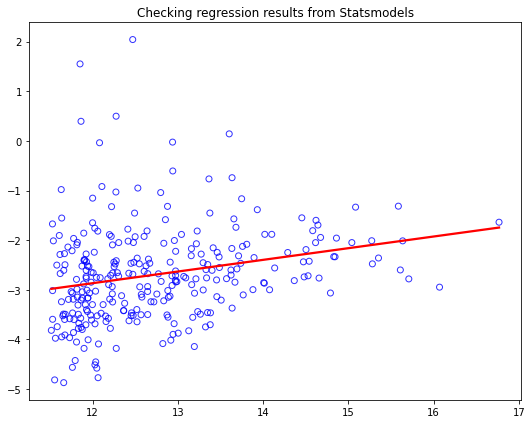

In [24]:
pred_ols = results.get_prediction()
plot_regplot(df_mfg, x='pop_2012', x_log=True, y='export_intensity_2012', y_log=True, 
             x_label='', y_label='', title='Checking regression results from Statsmodels')

## 3. Figure 1: Plot (city size, export intensity)

Text(0.5, 1.0, 'United States (sales only from manufacturing industry)')

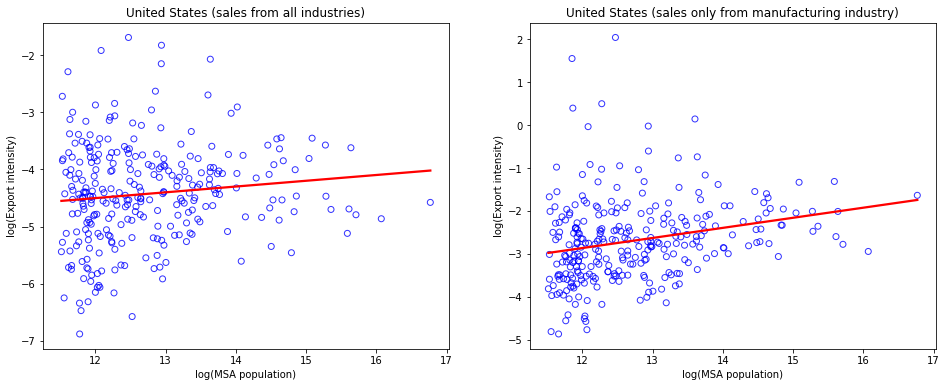

In [25]:
fig, axs = plt.subplots(1,2, figsize=(16,6))

# Plot all industries
sns.regplot(x=np.log(df['pop_2012']), y=np.log(df['export_intensity_2012']), ci=None, scatter_kws={'color':'blue', 'facecolor':'None'}, line_kws={'color':'red'}, ax=axs[0])
axs[0].set_xlabel('log(MSA population)')
axs[0].set_ylabel('log(Export intensity)')
axs[0].set_title('United States (sales from all industries)')

# Plot manufactuing industry
sns.regplot(x=np.log(df_mfg['pop_2012']), y=np.log(df_mfg['export_intensity_2012']), ci=None, scatter_kws={'color':'blue', 'facecolor':'None'}, line_kws={'color':'red'}, ax=axs[1])
axs[1].set_xlabel('log(MSA population)')
axs[1].set_ylabel('log(Export intensity)')
axs[1].set_title('United States (sales only from manufacturing industry)')

## 4. Regression of export intensity against population density

In [26]:
results = run_reg(df_mfg, y=['export_intensity_2012'], x_log=['pop_density_2012'])

                              OLS Regression Results                             
Dep. Variable:     export_intensity_2012   R-squared:                       0.003
Model:                               OLS   Adj. R-squared:                  0.000
Method:                    Least Squares   F-statistic:                     1.004
Date:                   Fri, 24 Mar 2023   Prob (F-statistic):              0.317
Time:                           08:42:51   Log-Likelihood:                -398.94
No. Observations:                    290   AIC:                             801.9
Df Residuals:                        288   BIC:                             809.2
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const     

In [27]:
results = run_reg(df_mfg, y=['export_intensity_2012'], x_nolog=['pop_density_2012'])

                              OLS Regression Results                             
Dep. Variable:     export_intensity_2012   R-squared:                       0.020
Model:                               OLS   Adj. R-squared:                  0.017
Method:                    Least Squares   F-statistic:                     5.997
Date:                   Fri, 24 Mar 2023   Prob (F-statistic):             0.0149
Time:                           08:42:51   Log-Likelihood:                -396.46
No. Observations:                    290   AIC:                             796.9
Df Residuals:                        288   BIC:                             804.3
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const     

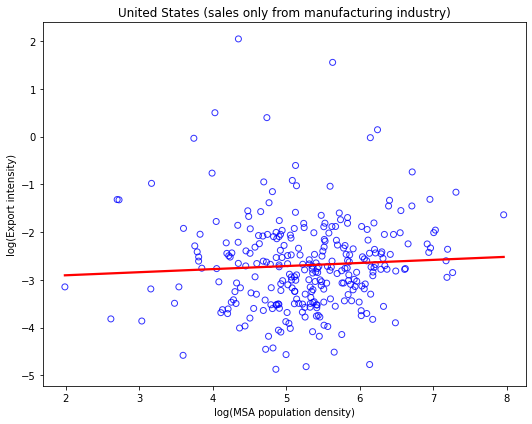

In [28]:
plot_regplot(df_mfg, x='pop_density_2012', x_log=True, y='export_intensity_2012', y_log=True, 
             x_label='log(MSA population density)', y_label='log(Export intensity)', title='United States (sales only from manufacturing industry)',
             savefig=r'C:\Users\jasonjia\Dropbox\projects\replication_cities_hetfirms\output\scatterplots\export_intensity_log_pop_density.png')

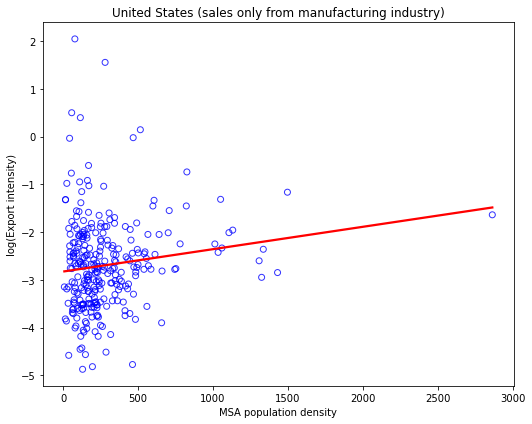

In [29]:
plot_regplot(df_mfg, x='pop_density_2012', x_log=False, y='export_intensity_2012', y_log=True, 
             x_label='MSA population density', y_label='log(Export intensity)', title='United States (sales only from manufacturing industry)',
             savefig=r'C:\Users\jasonjia\Dropbox\projects\replication_cities_hetfirms\output\scatterplots\export_intensity_pop_density.png')

## 5. Scatterplot of (share of employment by industry, log(Export intensity))

Number of industries: 21


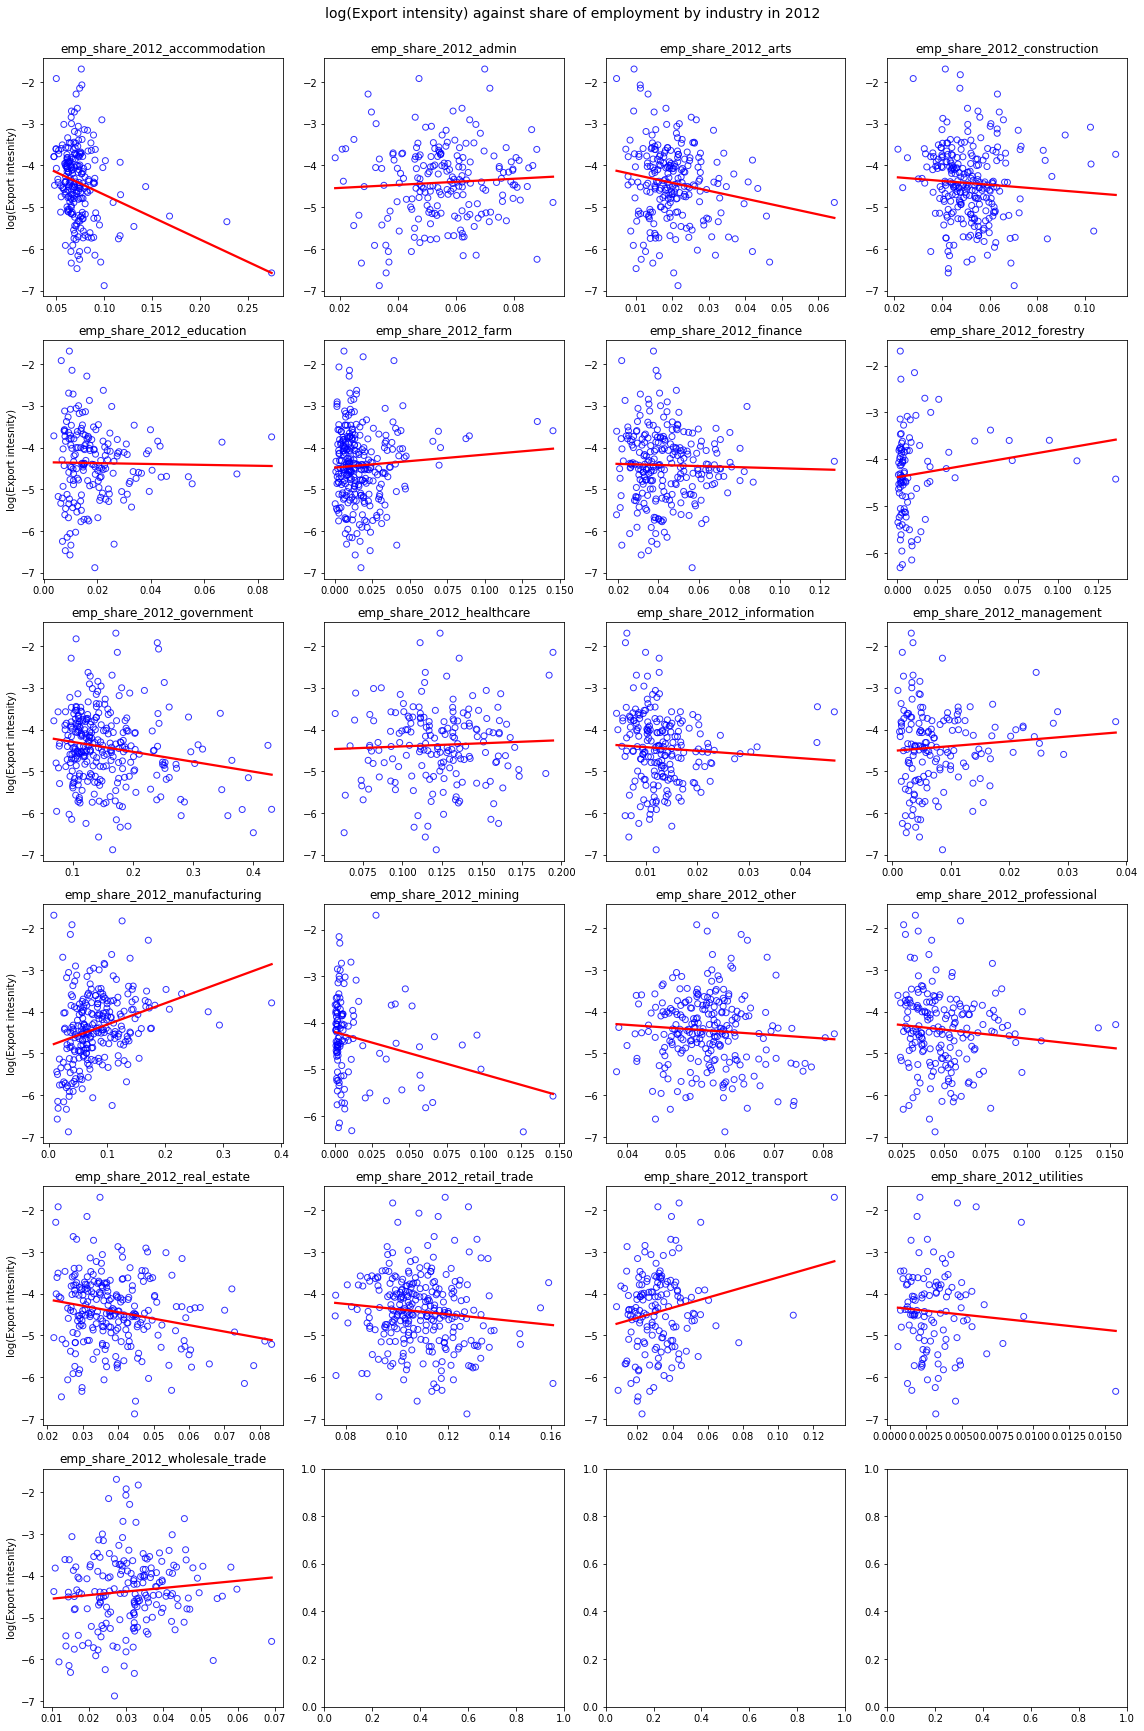

In [30]:
emp_share_cols = [col for col in df_mfg.columns if 'emp_share_2012' in col]
print("Number of industries:", len(emp_share_cols))
fig, axs = plt.subplots(6,4, figsize=(16,24))
for i, emp_share_col in enumerate(emp_share_cols):
    r, c = i // 4, i % 4
    sns.regplot(x=df[emp_share_col], y=np.log(df['export_intensity_2012']), ci=None, scatter_kws={'color':'blue', 'facecolor':'None'}, line_kws={'color':'red'}, ax=axs[r][c])
    axs[r][c].set_title(emp_share_col)
    axs[r][c].set_xlabel('')
    if c == 0:
        axs[r][c].set_ylabel('log(Export intesnity)')
    else:
        axs[r][c].set_ylabel('')
fig.suptitle('log(Export intensity) against share of employment by industry in 2012', y=1, fontsize=14)
fig.tight_layout()
fig.savefig(r'C:\Users\jasonjia\Dropbox\projects\replication_cities_hetfirms\output\scatterplots\export_intensity_emp_share_by_ind.png', dpi=200)

## 6. Regression of export intensity against population density and industry shares (manufacturing, retail trade, wholesale trade, government)

In [31]:
results = run_reg(df_mfg, y=['export_intensity_2012'], x_log=['pop_density_2012','emp_share_2012_manufacturing', 'emp_share_2012_retail_trade', 
                                                             'emp_share_2012_wholesale_trade', 'emp_share_2012_government'])

                              OLS Regression Results                             
Dep. Variable:     export_intensity_2012   R-squared:                       0.182
Model:                               OLS   Adj. R-squared:                  0.158
Method:                    Least Squares   F-statistic:                     7.767
Date:                   Fri, 24 Mar 2023   Prob (F-statistic):           1.27e-06
Time:                           08:42:56   Log-Likelihood:                -240.69
No. Observations:                    181   AIC:                             493.4
Df Residuals:                        175   BIC:                             512.6
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

In [32]:
results = run_reg(df_mfg, y=['export_intensity_2012'], x_log=['pop_density_2012'], x_nolog=['emp_share_2012_manufacturing', 'emp_share_2012_retail_trade', 
                                                             'emp_share_2012_wholesale_trade', 'emp_share_2012_government'])

                              OLS Regression Results                             
Dep. Variable:     export_intensity_2012   R-squared:                       0.137
Model:                               OLS   Adj. R-squared:                  0.112
Method:                    Least Squares   F-statistic:                     5.559
Date:                   Fri, 24 Mar 2023   Prob (F-statistic):           8.86e-05
Time:                           08:42:56   Log-Likelihood:                -245.49
No. Observations:                    181   AIC:                             503.0
Df Residuals:                        175   BIC:                             522.2
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

## 7. Regression of export intensity against population and industry shares (manufacturing, retail trade, wholesale trade, government)

In [33]:
results = run_reg(df_mfg, y=['export_intensity_2012'], x_log=['pop_2012','emp_share_2012_manufacturing', 'emp_share_2012_retail_trade', 
                                                             'emp_share_2012_wholesale_trade', 'emp_share_2012_government'])

                              OLS Regression Results                             
Dep. Variable:     export_intensity_2012   R-squared:                       0.198
Model:                               OLS   Adj. R-squared:                  0.175
Method:                    Least Squares   F-statistic:                     8.624
Date:                   Fri, 24 Mar 2023   Prob (F-statistic):           2.53e-07
Time:                           08:42:56   Log-Likelihood:                -238.90
No. Observations:                    181   AIC:                             489.8
Df Residuals:                        175   BIC:                             509.0
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

In [34]:
results = run_reg(df_mfg, y=['export_intensity_2012'], x_log=['pop_2012'], x_nolog=['emp_share_2012_manufacturing', 'emp_share_2012_retail_trade', 
                                                             'emp_share_2012_wholesale_trade', 'emp_share_2012_government'])

                              OLS Regression Results                             
Dep. Variable:     export_intensity_2012   R-squared:                       0.156
Model:                               OLS   Adj. R-squared:                  0.132
Method:                    Least Squares   F-statistic:                     6.456
Date:                   Fri, 24 Mar 2023   Prob (F-statistic):           1.56e-05
Time:                           08:42:56   Log-Likelihood:                -243.51
No. Observations:                    181   AIC:                             499.0
Df Residuals:                        175   BIC:                             518.2
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------